In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code
Enter your authorization code:


In [0]:
!cp drive/My\ Drive/Colab_Notebooks/IC/Training_Week_3/mnist_test.csv .
!cp drive/My\ Drive/Colab_Notebooks/IC/Training_Week_3/mnist_train.csv .

In [0]:
!pip3 -qq install torch torchvision

In [0]:
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix




In [0]:
def split_train_validation(dataset):
    df_train = pd.DataFrame()
    df_validation = pd.DataFrame()
    for i in range(10):
        selection = dataset['5'] == i
        df_selection = dataset[selection]
        df_train_aux = df_selection.sample(frac = 0.8)
        df_validation_aux = df_selection.drop(df_train_aux.index)
        df_train = pd.concat([df_train, df_train_aux])
        df_validation = pd.concat([df_validation, df_validation_aux])
    df_train = df_train.sample(frac = 1).reset_index(drop = True)
    df_validation = df_validation.sample(frac = 1).reset_index(drop = True)
    return df_train, df_validation

def adjust_data(dataset):
    pixels = dataset.iloc[:, 1:].values/255
    n_examples = pixels.shape[0]
    
    imgs = np.ndarray(shape = (n_examples, 1, 28, 28), dtype = "float")
    for i in range(0, n_examples):
        imgs[i, 0, :, :] = pixels[i, :].reshape(28, 28)
    return imgs

In [0]:
epochs = 20
batch_size = 2
learning_rate = 0.001

In [0]:
df = pd.read_csv("mnist_train.csv")
df_test = pd.read_csv("mnist_test.csv")

In [22]:
df_train, df_validation = split_train_validation(df)

X_train = torch.FloatTensor(adjust_data(df_train))
y_train = torch.from_numpy(df_train.iloc[:, :1].values)
X_validation = torch.FloatTensor(adjust_data(df_validation))
y_validation = torch.from_numpy(df_validation.iloc[:, :1].values)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

(torch.Size([47999, 1, 28, 28]),
 torch.Size([47999, 1]),
 torch.Size([12000, 1, 28, 28]),
 torch.Size([12000, 1]))

In [0]:
train_set = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)

validation_set = torch.utils.data.TensorDataset(X_validation, y_validation)
validation_loader = torch.utils.data.DataLoader(validation_set, y_validation.data.size()[0], shuffle = False)

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(320, 120)
        self.fc1_drop = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(120, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1_drop(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
net



Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.25)
  (fc1): Linear(in_features=320, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.25)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

optmizer = optim.Adam(net.parameters())
eq_loss = nn.CrossEntropyLoss()

In [0]:
## Train
for epoch in range(epochs):
    tot_loss = 0
    net.train()
    for batch, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs).cuda(), Variable(torch.squeeze(targets)).cuda()
        optmizer.zero_grad()
        outputs = net(inputs)
        loss = eq_loss(outputs, targets)
        tot_loss += loss
        loss.backward()
        optmizer.step()
    print('Epoch: {}\nTrain Loss: {}'.format(epoch, tot_loss))

## Validation
    best_loss = 1
    total_cnt = 0
    correct_cnt = 0
    test_loss = 0
    net.eval()
    for inputs, targets in validation_loader:
        inputs, targets = Variable(inputs).cuda(), Variable(torch.squeeze(targets)).cuda()
        output = Variable(net(inputs))
        test_loss += eq_loss(output, targets)
        _, pred_label = torch.max(output, 1)
        prediction = np.array(pred_label)
        target = np.array(targets)
        total_cnt = target.shape[0]
        for i in range(target.shape[0]):
            if prediction[i] == target[i]:
                correct_cnt += 1
    if test_loss < best_loss:
        net_f = net
    print("Validation Loss - {} // Acc - {}".format(test_loss, 100*correct_cnt/total_cnt))
    
net = net_f

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
## Test
X_test = torch.FloatTensor(adjust_data(df_test))
y_test = torch.from_numpy(df_test.iloc[:, :1].values)

test_set = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = y_test.data.size()[0], shuffle = False)

X_test.shape, y_test.shape

(torch.Size([9999, 1, 28, 28]), torch.Size([9999, 1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Teste/n Loss - 0.03563344478607178 // Acc - 99.12991299129914


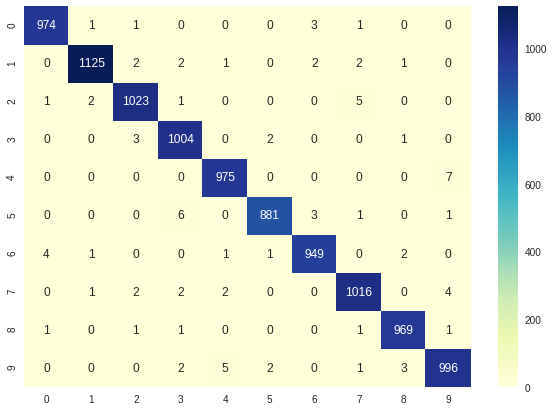

In [14]:
total_cnt = 0
correct_cnt = 0
test_loss = 0
net.eval()
for inputs, targets in test_loader:
    inputs, targets = Variable(inputs).cuda(), Variable(torch.squeeze(targets)).cuda()
    output = Variable(net(inputs))
    test_loss += eq_loss(output, targets)
    _, pred_label = torch.max(output, 1)
    prediction = np.array(pred_label)
    target = np.array(targets)
    total_cnt = target.shape[0]
    for i in range(target.shape[0]):
        if prediction[i] == target[i]:
            correct_cnt += 1
print("Teste/n Loss - {} // Acc - {}".format(test_loss, 100*correct_cnt/total_cnt))

array = confusion_matrix(target, prediction)
df_cm = pd.DataFrame(array, index = [i for i in'0123456789'], columns = [i for i in '0123456789'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt = "d")